In [11]:
%matplotlib inline
import zounds
from IPython.display import Audio, display
from matplotlib import pyplot as plt

samplerate = zounds.SR11025()
BaseModel = zounds.resampled(resample_to=samplerate, store_resampled=True)
wscheme = zounds.SampleRate(
    frequency = samplerate.frequency * 1024,
    duration = samplerate.frequency * 8192)

@zounds.simple_in_memory_settings
class Sound(BaseModel):
    windowed = zounds.ArrayWithUnitsFeature(
        zounds.SlidingWindow,
        wscheme=wscheme,
        wfunc=None,
        needs=BaseModel.resampled)
    
_id = Sound.process(meta='https://archive.org/download/LucaBrasi2/06-Kevin_Gates-Out_The_Mud_Prod_By_The_Runners_The_Monarch.ogg')
snd = Sound(_id)
print snd.meta

{u'description': None, u'tags': None, u'uri': u'https://archive.org/download/LucaBrasi2/06-Kevin_Gates-Out_The_Mud_Prod_By_The_Runners_The_Monarch.ogg', u'channels': None, u'licensing': None, u'samplerate': None}


In [59]:
import numpy as np

# scale_bands = [zounds.FrequencyBand(0, 20)]
# stops = np.logspace(np.log10(20), np.log10(samplerate.nyquist), 1024)
# for i, stop in enumerate(stops):
#     scale_bands.append(zounds.FrequencyBand(scale_bands[i].start_hz, stop))    
# scale = zounds.ExplicitScale(scale_bands)
scale = zounds.MelScale(zounds.FrequencyBand(20, samplerate.nyquist - 300), 1024)
print scale

MelScale(band=FrequencyBand(
start_hz=20,
stop_hz=5212,
center=2616.0,
bandwidth=5192), n_bands=1024)


In [60]:
import torch
from torch.autograd import Variable
from scipy.signal import gaussian

frequency_window=gaussian(100, 3)
basis_size = 512
basis = zounds.spectral.fir_filter_bank(
    scale, basis_size, samplerate, frequency_window)
weights = Variable(torch.from_numpy(basis).float())
# out channels x in channels x kernel width
weights = weights.view(len(scale), 1, basis_size).contiguous()
print weights

Variable containing:
( 0  ,.,.) = 
 -2.7067e-05 -2.7075e-05 -2.7102e-05  ...  -2.7102e-05 -2.7075e-05 -2.7067e-05

( 1  ,.,.) = 
 -1.5409e-04 -1.5414e-04 -1.5429e-04  ...  -1.5429e-04 -1.5414e-04 -1.5409e-04

( 2  ,.,.) = 
 -3.4731e-05 -3.4741e-05 -3.4775e-05  ...  -3.4775e-05 -3.4741e-05 -3.4731e-05
 ... 

(1021,.,.) = 
  2.9071e-06  1.1022e-06 -5.2976e-06  ...  -5.2976e-06  1.1022e-06  2.9071e-06

(1022,.,.) = 
 -2.0710e-05  2.0617e-05 -1.9846e-05  ...  -1.9846e-05  2.0617e-05 -2.0710e-05

(1023,.,.) = 
  6.8168e-06 -1.0319e-05  1.3718e-05  ...   1.3718e-05 -1.0319e-05  6.8168e-06
[torch.FloatTensor of size 1024x1x512]



In [61]:
samples = snd.windowed[180]
Audio(samples, rate=int(samplerate))

torch.Size([1024, 1, 7681])


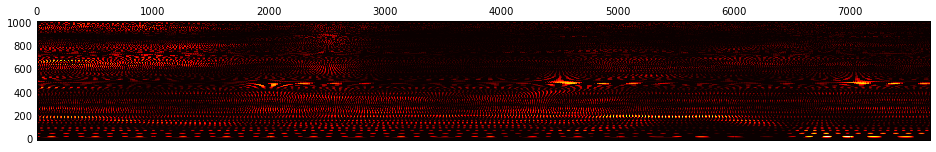

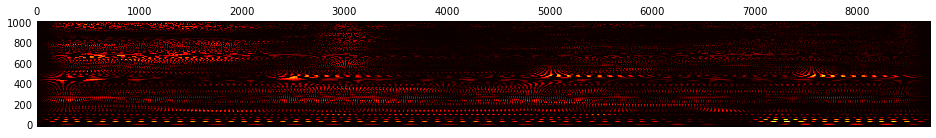

In [107]:
from torch.nn import functional as F

log_factor = 1000

samples_v = Variable(torch.from_numpy(samples).float())
win = samples_v.unfold(-1, 512, 1)
spec = torch.matmul(weights, win.t())
spec = F.relu(spec)
spec = torch.log(1 + spec * log_factor)
print spec.shape

plt.matshow(spec.data.cpu().numpy().squeeze(), origin='lower', cmap='hot')
plt.show()

features = F.conv1d(samples_v.view(1, 1, 8192), weights, stride=1, padding=basis_size)


# half-wave rectification
features = F.relu(features)

# log magnitude
features = torch.log(1 + features * log_factor)

plt.matshow(features.data.cpu().numpy().squeeze(), origin='lower', cmap='hot')
plt.show()

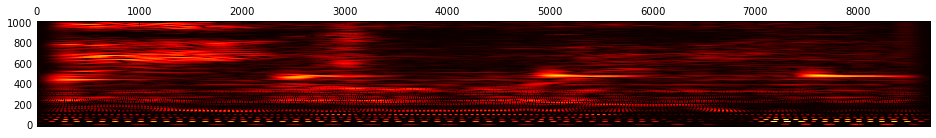

In [118]:
kernel = Variable(torch.from_numpy(np.ones((5, 5), dtype=np.float32))).view(1, 1, 5, 5)
patches = F.conv2d(features.view(1, 1, len(scale), -1), kernel, stride=(3, 3))

smoothed = F.max_pool2d(features.view(1, 1, len(scale), -1), (1, 10), (1, 1)).view(1, len(scale), -1)


plt.matshow(smoothed.data.cpu().numpy().squeeze(), origin='lower', cmap='hot')
plt.show()